# Minimal example of using QuPulse 2-channel pulse and ATSaverage `chunkedAverage`

This notebook uses QuPulse to put out a 2-channel pulse, where some interesting pulse it played on channel `1-A` and a less interesting pulse for triggering is played on channel `3-B`. It also sets up an atssimple measurement for measuring the output when using channel `3-B` as a trigger.

The notebook does not make use of dedicated marker channels.

In [ ]:
import qupulse
import qupulse.pulses.plotting
import qupulse.hardware.awgs.zihdawg
import qupulse.hardware.dacs.atssimple

import atssimple
import atssimple.atsapi

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches

import logging
import sys

%matplotlib inline

Setup logging

In [2]:
logging.basicConfig(stream=sys.stdout)

QuPulse pulse shenanigans, now with measurements

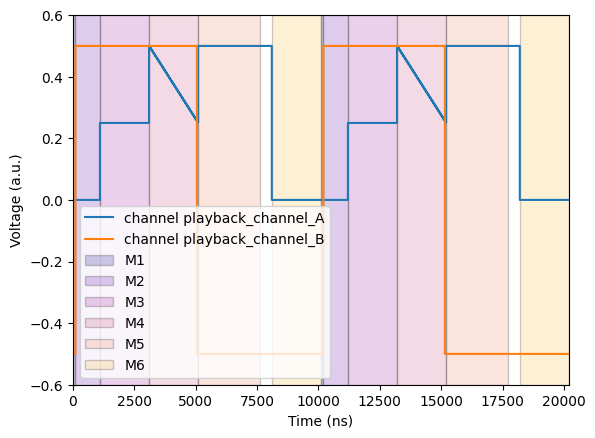

In [3]:
pulse_template = qupulse.pulses.TablePT(
    {
        "playback_channel_A": [
            (0, 0),
            ("t_delay * time_unit", 0, "hold"),
            ("(t_delay + 1000) * time_unit", "holdc0v1", "hold"),
            ("(t_delay + 1000 + 2000) * time_unit", "holdc0v2", "hold"),
            ("(t_delay + 3000 + 2000) * time_unit", "linc0v3", "linear"),
            ("(t_delay + 5000 + 3000) * time_unit", "jumpc0v4", "jump"),
            ("(t_delay + 8000 + 2000) * time_unit", "jumpc0v5", "jump"),
        ],
        "playback_channel_B": [
            (0, -0.5),
            ("100 * time_unit", 0.5, "hold"),
            ("(t_delay/2 + 10000/2) * time_unit", -0.5, "hold"),
            ("(t_delay + 10000) * time_unit", -0.5, "hold"),
        ],
    },
    measurements=[
        ("M1", "0 * time_unit", "t_delay * time_unit"),
        ("M2", "t_delay * time_unit", "1000 * time_unit"),
        ("M3", "(t_delay + 1000) * time_unit", "2000 * time_unit"),
        ("M4", "(t_delay + 3000) * time_unit", "2000 * time_unit"),
        ("M5", "(t_delay + 5000) * time_unit", "2500 * time_unit"), # This mask leaves a gap
        ("M6", "(t_delay + 8000) * time_unit", "2000 * time_unit"),
    ],
)

reps = 2
pulse_template = pulse_template.with_repetition(reps)

params = {
    "t_delay": 100,
    "holdc0v1": 0.25,
    "holdc0v2": 0.5,
    "linc0v3": 0.25,
    "jumpc0v4": 0.5,
    "jumpc0v5": 0,
    "time_unit": 1,
}

_ = qupulse.pulses.plotting.plot(
    pulse_template,
    params,
    sample_rate=0.1/1,
    plot_measurements=pulse_template.measurement_names,
)

Initialize program with the given parameters

In [4]:
pulse_program = pulse_template.create_program(parameters=params)

Setup AlazarCard configuration

In [5]:
board = atssimple.atsapi.Board(systemId=1, boardId=1)

samples_per_sec = 125000000.0
board.setCaptureClock(
    atssimple.atsapi.INTERNAL_CLOCK,
    atssimple.atsapi.SAMPLE_RATE_125MSPS,
    atssimple.atsapi.CLOCK_EDGE_RISING,
    0,
)

board.inputControlEx(
    atssimple.atsapi.CHANNEL_A,
    atssimple.atsapi.DC_COUPLING,
    atssimple.atsapi.INPUT_RANGE_PM_1_V,
    atssimple.atsapi.IMPEDANCE_50_OHM,
)

board.inputControlEx(
    atssimple.atsapi.CHANNEL_B,
    atssimple.atsapi.DC_COUPLING,
    atssimple.atsapi.INPUT_RANGE_PM_1_V,
    atssimple.atsapi.IMPEDANCE_50_OHM,
)

board.inputControlEx(
    atssimple.atsapi.CHANNEL_C,
    atssimple.atsapi.DC_COUPLING,
    atssimple.atsapi.INPUT_RANGE_PM_1_V,
    atssimple.atsapi.IMPEDANCE_50_OHM,
)

board.inputControlEx(
    atssimple.atsapi.CHANNEL_D,
    atssimple.atsapi.DC_COUPLING,
    atssimple.atsapi.INPUT_RANGE_PM_1_V,
    atssimple.atsapi.IMPEDANCE_50_OHM,
)

board.setTriggerOperation(
    atssimple.atsapi.TRIG_ENGINE_OP_J,
    atssimple.atsapi.TRIG_ENGINE_J,
    atssimple.atsapi.TRIG_CHAN_B,
    atssimple.atsapi.TRIGGER_SLOPE_POSITIVE,
    150,
    atssimple.atsapi.TRIG_ENGINE_K,
    atssimple.atsapi.TRIG_DISABLE,
    atssimple.atsapi.TRIGGER_SLOPE_POSITIVE,
    128,
)

board.setExternalTrigger(atssimple.atsapi.DC_COUPLING, atssimple.atsapi.ETR_5V)

triggerDelay_sec = 0
triggerDelay_samples = int(triggerDelay_sec * samples_per_sec + 0.5)
board.setTriggerDelay(triggerDelay_samples)

triggerTimeout_sec = 0
triggerTimeout_clocks = int(triggerTimeout_sec / 10e-6 + 0.5)
board.setTriggerTimeOut(triggerTimeout_clocks)

board.configureAuxIO(atssimple.atsapi.AUX_OUT_TRIGGER, 0)

Create HardwareSetup object that holds awgs and dacs and handles their shared information

In [6]:
HardwareSetup = qupulse.hardware.setup.HardwareSetup()

Create awg handle and register its used playback channel to the HardwareSetup.
This also creates the connection between the channel name in the program and the physical device channel

In [7]:
awg = qupulse.hardware.awgs.zihdawg.HDAWGRepresentation(device_serial="DEV8899", device_interface="USB", timeout=10)

In [8]:
HardwareSetup.set_channel(
    "playback_channel_A",
    [qupulse.hardware.setup.PlaybackChannel(awg.channel_tuples[0], 0)],
)
HardwareSetup.set_channel(
    "playback_channel_B",
    qupulse.hardware.setup.PlaybackChannel(awg.channel_tuples[0], 1),
)

Create qupulse dac (AlazarCard) handle. This is required in order to communicate the measurement windows with the AlazarCard.

In [9]:
dac = qupulse.hardware.dacs.atssimple.ATSSimpleCard()

Let QuPulse know the connection between the pulse measurement windows and atssimple measurements.

In [10]:
HardwareSetup.set_measurement('M1', [qupulse.hardware.setup.MeasurementMask(dac, 'M1')])
HardwareSetup.set_measurement('M2', [qupulse.hardware.setup.MeasurementMask(dac, 'M2')])
HardwareSetup.set_measurement('M3', [qupulse.hardware.setup.MeasurementMask(dac, 'M3')])
HardwareSetup.set_measurement('M4', [qupulse.hardware.setup.MeasurementMask(dac, 'M4')])
HardwareSetup.set_measurement('M5', [qupulse.hardware.setup.MeasurementMask(dac, 'M5')])
HardwareSetup.set_measurement('M6', [qupulse.hardware.setup.MeasurementMask(dac, 'M6')])

This completes the HardwareSetup, we can thus register program.
Here `run_callback` needs to be specified because otherwise no trigger action is performed.

In [11]:
# This disables the Software trigger for the HDAWG
awg.channel_tuples[0]._program_manager._compiler_settings[0][1]["trigger_wait_code"] = ""

HardwareSetup.remove_program("playground_program")
HardwareSetup.register_program("playground_program", pulse_program, run_callback=awg.channel_tuples[0].run_current_program)

Register additional operation information. AtsSimple simply requires the sample rate used for each measurement.

In [12]:
operations = {
    "M1": 25e06,
    "M2": 25e06,
    "M3": 25e06,
    "M4": 25e06,
    "M5": 25e06,
    "M6": 25e06,
}

In [13]:
dac.register_operations("playground_program", operations)

Run the program. This also compiles and uploads it to the awg.

**Remember to turn on Outputs!**

In [14]:
HardwareSetup.run_program("playground_program")

Get the results and plot.

In [15]:
my_scanline_result = dac.measure_program(["M1", "M2", "M3", "M4", "M5", "M6"])

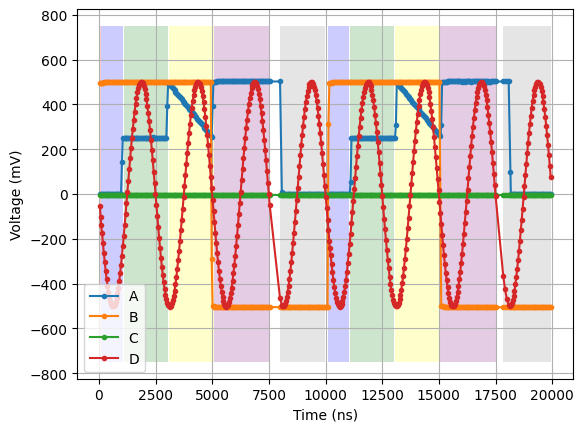

In [16]:
voltages = {}
voltages['A'] = np.concatenate([np.concatenate([my_scanline_result[f"M{index}"][rep][1][0] for index in [1,2,3,4,5,6]]) for rep in range(reps)]) * 1e03 # mV
voltages['B'] = np.concatenate([np.concatenate([my_scanline_result[f"M{index}"][rep][1][1] for index in [1,2,3,4,5,6]]) for rep in range(reps)]) * 1e03 # mV
voltages['C'] = np.concatenate([np.concatenate([my_scanline_result[f"M{index}"][rep][1][2] for index in [1,2,3,4,5,6]]) for rep in range(reps)]) * 1e03 # mV
voltages['D'] = np.concatenate([np.concatenate([my_scanline_result[f"M{index}"][rep][1][3] for index in [1,2,3,4,5,6]]) for rep in range(reps)]) * 1e03 # mV

t = np.concatenate([np.concatenate([my_scanline_result[f"M{index}"][rep][0] for index in [1,2,3,4,5,6]]) for rep in range(reps)]) * 1e09 # ns

plt.plot(t, voltages["A"], marker='.', linestyle='solid', label="A")
plt.plot(t, voltages["B"], marker='.', linestyle='solid', label="B")
plt.plot(t, voltages["C"], marker='.', linestyle='solid', label="C")
plt.plot(t, voltages["D"], marker='.', linestyle='solid', label="D")

ax = plt.gca()
mcolors = ["red", "blue", "green", "yellow", "purple", "gray"]
for index in [1,2,3,4,5,6]:
    for rep in range(reps):
        r = pltpatches.Rectangle(((x0 := my_scanline_result[f"M{index}"][rep][0][0] * 1e09), -750), my_scanline_result[f"M{index}"][rep][0][-1] * 1e09 - x0, 1500, facecolor=mcolors[index-1], alpha=0.2)
        ax.add_patch(r)
        

plt.xlabel('Time (ns)')
plt.ylabel('Voltage (mV)')

plt.grid()
plt.legend()

plt.show()